In [928]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy

In [929]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28253 entries, 0 to 28252
Data columns (total 5 columns):
Code                28253 non-null category
Blood_Glucose       28253 non-null float64
Patient_ID          28253 non-null int64
Code_Description    28253 non-null object
Date_Time           28253 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 911.4+ KB


In [930]:
df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


In [931]:
group_df = df.groupby('Patient_ID')

df_agg = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<70]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days))
})



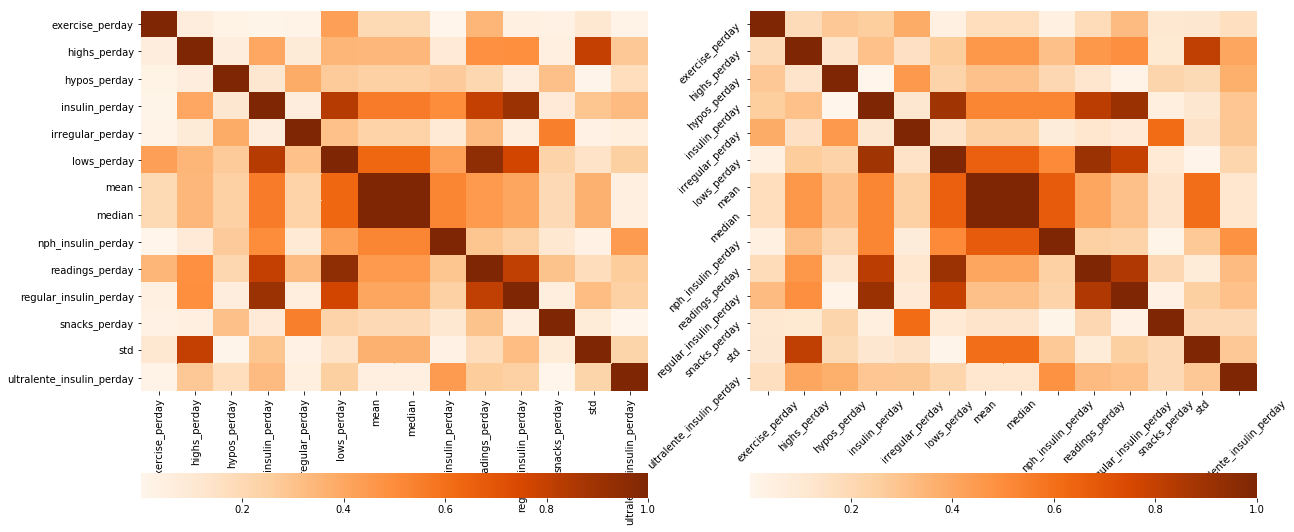

In [932]:
plt.subplot(1, 2, 1)
fig = plt.gcf()
fig.set_size_inches(20, 10, forward=True)
corr = df_agg.corr()
plt.yticks(rotation=45) 
plt.xticks(rotation=45)
sns.heatmap(np.absolute(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges', cbar_kws={"orientation": "horizontal"})
#plt.show()


plt.subplot(1, 2, 2)
corr = df_agg[df_agg.loc[:,'hypos_perday']>0.0].corr()
#fig = plt.gcf()
#fig.set_size_inches(10, 7, forward=True)
sns.heatmap(np.absolute(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges', cbar_kws={"orientation": "horizontal"})
plt.yticks(rotation=45) 
plt.xticks(rotation=45)
plt.show()

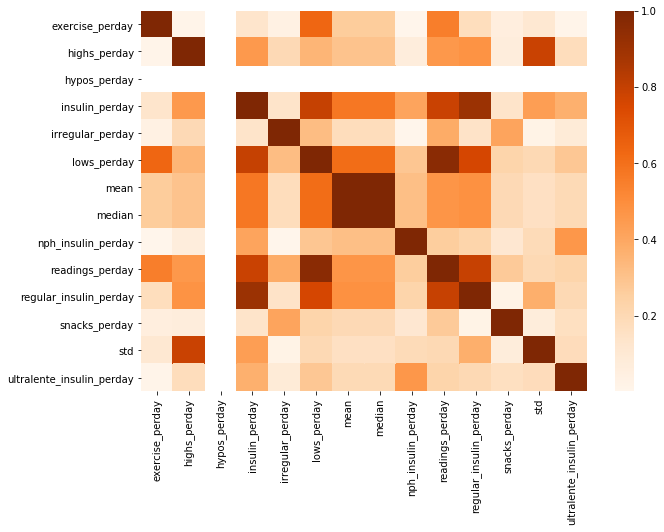

In [933]:
corr = df_agg[df_agg.loc[:,'hypos_perday']==0.0].corr()
fig = plt.gcf()
fig.set_size_inches(10, 7, forward=True)

sns.heatmap(np.absolute(corr), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges')
plt.show()

In [934]:
df_agg_plot = df_agg.reset_index().drop('Patient_ID', axis = 1)

df_agg_plot['Hypo_Flag'] = 'Non_Hypoglycemic'

df_agg_plot.loc[df_agg_plot['hypos_perday']>0.0, 'Hypo_Flag'] = 'Hypoglycemic'

df_agg_plot['Hypo_Flag'].unique()

df_agg_plot = pd.melt(df_agg_plot, id_vars=['Hypo_Flag'], var_name='params')

df_agg_plot.head()

,Hypo_Flag,params,value
0,Hypoglycemic,exercise_perday,0.0
1,Non_Hypoglycemic,exercise_perday,0.0
2,Hypoglycemic,exercise_perday,0.0
3,Hypoglycemic,exercise_perday,0.0
4,Non_Hypoglycemic,exercise_perday,0.0


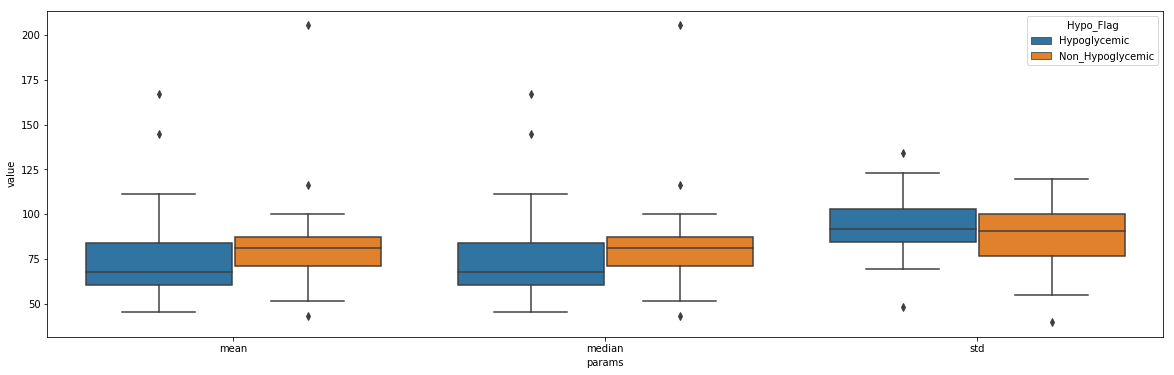

In [935]:
fig = plt.gcf()
fig.set_size_inches(20, 6, forward=True)
sns.boxplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'mean') | (df_agg_plot['params']  == 'median') | (df_agg_plot['params']  == 'std')])    
plt.show()

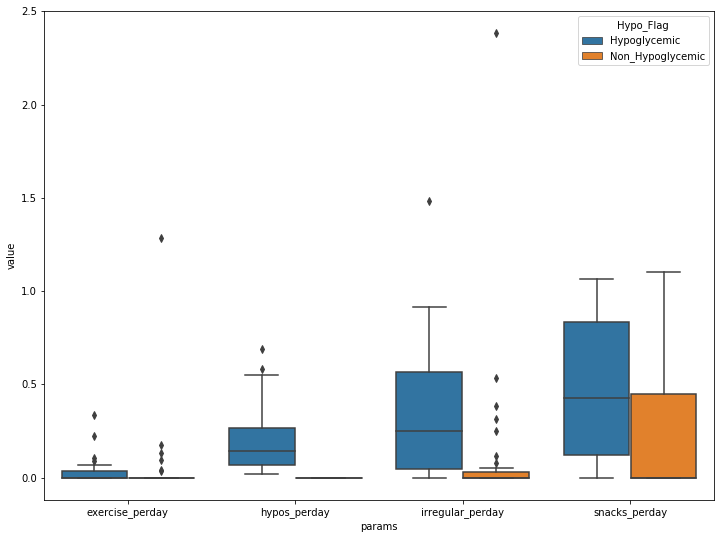

In [936]:
fig = plt.gcf()
fig.set_size_inches(12, 9, forward=True)
sns.boxplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'exercise_perday') | (df_agg_plot['params']  == 'hypos_perday') | (df_agg_plot['params']  == 'irregular_perday') | (df_agg_plot['params']  == 'snacks_perday')])    
plt.show()

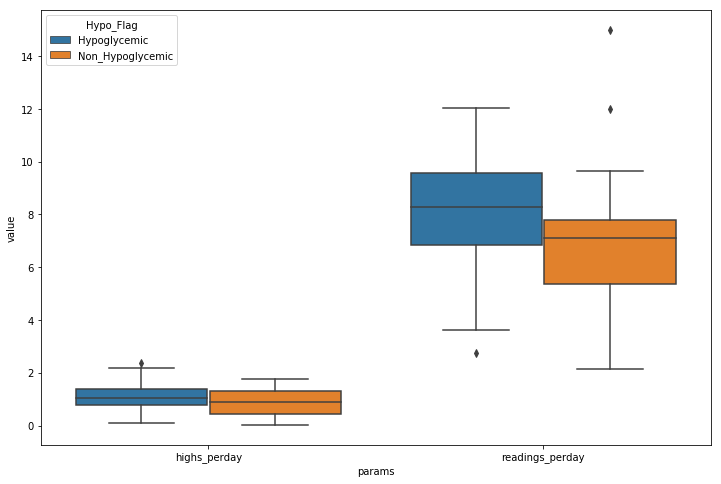

In [937]:
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)
sns.boxplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'highs_perday') | (df_agg_plot['params']  == 'readings_perday')])    
plt.show()

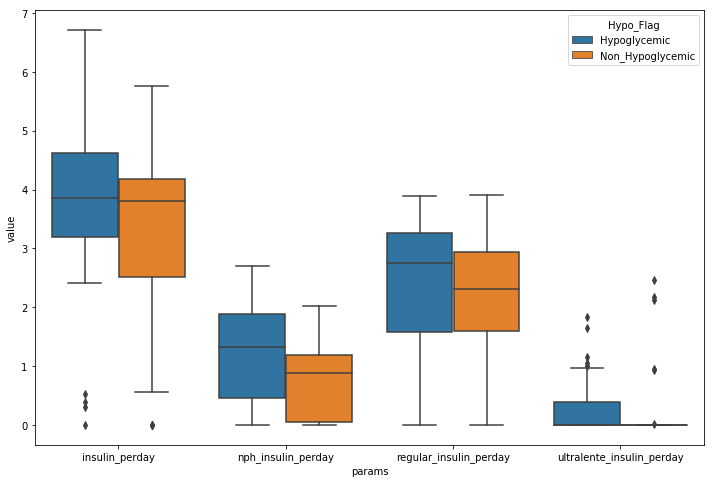

In [938]:
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)
sns.boxplot(x="params", y="value", hue="Hypo_Flag", data=df_agg_plot.loc[(df_agg_plot['params']  == 'regular_insulin_perday') | (df_agg_plot['params']  == 'nph_insulin_perday') | (df_agg_plot['params']  == 'ultralente_insulin_perday') | (df_agg_plot['params']  == 'insulin_perday')])    
plt.show()

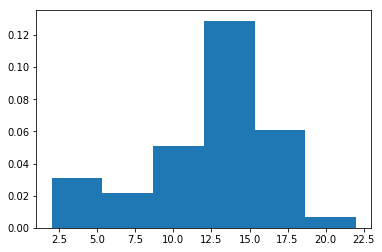

In [939]:
df.loc[df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS', 'Date_Time']

plt.hist(pd.Series(df.loc[df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS', 'Date_Time'].dt.hour), bins=6, normed=True)
plt.show()

In [940]:
df.iloc[df.index[df.Code_Description == 'HYPOGLYCEMIC_SYMPTOMS'] - 1].groupby('Code_Description').count()

,Code,Blood_Glucose,Patient_ID,Date_Time
Code_Description,,,,
HYPOGLYCEMIC_SYMPTOMS,5,5,5,5
LESS_EXERCISE,1,1,1,1
MORE_EXERCISE,4,4,4,4
MORE_MEAL_INJESTION,6,6,6,6
NPH_INSULIN_DOSE,84,84,84,84
POST_BREAKFAST,1,1,1,1
POST_LUNCH,2,2,2,2
POST_SUPPER,1,1,1,1
PRE_BREAKFAST,14,14,14,14


In [948]:
def medianTime(groupSeries):
    groupSeries = np.sort(pd.to_datetime(groupSeries, "%m-%d-%Y %H:%M:%S").dt.time)
    return pd.to_datetime(str(groupSeries[int(len(groupSeries)/2)]), format ="%H:%M:%S")
    #return 0;

df2 = pd.DataFrame(df.groupby(['Patient_ID', 'Code_Description']).Date_Time.agg(medianTime)).reset_index()
df2 = df2[df2['Code_Description']!='UNKNOWN']

def cleanUnknownCode(row):
    minimum = None
    if(row['Code_Description'] == 'UNKNOWN'):
        #print("**********************")
        for index,iterrow in df2.loc[(row['Patient_ID'] == df2['Patient_ID']) & (df2['Code_Description']!='HYPOGLYCEMIC_SYMPTOMS')].iterrows():
            delta = pd.to_datetime(iterrow['Date_Time'], format="%H:%M:%S") - pd.to_datetime(row['Date_Time'].time(), format="%H:%M:%S")
            if(delta.days<0):
                delta = pd.to_datetime(row['Date_Time'].time(), format="%H:%M:%S") - pd.to_datetime(iterrow['Date_Time'], format="%H:%M:%S")
            
            #print("Delta Vs Minimum : "+str(delta)+" "+str(minimum))
            #print("Row values : "+str(row['Code_Description'])+" "+str(row['Date_Time']))
            #print("Iterrow values : "+str(iterrow['Code_Description'])+" "+str(iterrow['Date_Time']))
            if(minimum == None or delta.total_seconds()<=minimum.total_seconds()):
                #print("Old Minimum : "+str(minimum))
                #print("New Minimum : "+str(delta))
                #if(minimum!=None):
                #    print(str(minimum.total_seconds())+" Delta "+str(delta.total_seconds()))
                minimum = delta
                row['Code_Description'] = iterrow['Code_Description']   
        #print("YY"+str(row['Code_Description'])+" "+str(row['Date_Time']))
    return row

df = df.apply(lambda row : cleanUnknownCode(row), axis = 1).head()

df.head()
#pd.to_datetime(df2.loc[row['Patient_ID'] == df2['Patient_ID'],'Date_Time'], format ="%H:%M:%S") - 
#pd.to_datetime(df.loc[(df['Code_Description']=='UNKNOWN') & (df['Patient_ID']==31), 'Date_Time'].dt.time, format ="%H:%M:%S")

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00


In [831]:
df2.loc[df2['Patient_ID']==48, 'Date_Time'].dt.time

446    03:14:00
447    17:40:00
448    09:22:00
449    20:40:00
450    06:05:00
451    12:03:00
452    16:01:00
453    16:51:00
454    16:32:00
Name: Date_Time, dtype: object